# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [ ]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [2]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
with open('../../data/hopsworks-api-key.txt', 'r') as file:
   os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login(project="ID2223HT24G4")
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1167511
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [46]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
)
weather_fg = fs.get_feature_group(
    name='weather',
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [59]:
# Convert Spark DataFrame to Pandas DataFrame
pdf = air_quality_fg.select(['pm25']).join(weather_fg.select_all(), on=['city']).read()


# Create lagged features using shift
pdf['pm25_lag1'] = pdf['pm25'].shift(1)
pdf['pm25_lag2'] = pdf['pm25'].shift(2)
pdf['pm25_lag3'] = pdf['pm25'].shift(3)
pdf = pdf.dropna()
# Display the result
print(pdf.head(5))


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.86s) 
        pm25                      date  temperature_2m_mean  \
3  28.290001 2019-12-12 00:00:00+00:00             0.036083   
4  18.629999 2019-12-13 00:00:00+00:00             3.234000   
5  18.299999 2019-12-14 00:00:00+00:00             4.056916   
6   6.910000 2019-12-15 00:00:00+00:00             5.654833   
7   6.780000 2019-12-16 00:00:00+00:00             5.125666   

   precipitation_sum  wind_speed_10m_max  wind_direction_10m_dominant  \
3                0.0           15.941944                   160.212555   
4                0.5           24.946726                   139.545670   
5                0.4           27.103001                   184.513916   
6                2.0           23.344549                   230.455734   
7                0.0           19.093580                   202.801987   

       city  pm25_lag1  pm25_lag2  pm25_lag3  
3  Warszawa  29.459999  12.920000  17.000000  
4 

In [60]:
fg = fs.get_or_create_feature_group(
    name='air_quality_lagged',
    description='Air Quality characteristics of each day with lag',
    version=1,
    primary_key=['city', 'date'],
    event_time="date",
)

In [61]:
fg.insert(pdf)


Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1167511/fs/1158214/fg/1348991


Uploading Dataframe: 0.00% |          | Rows 0/1789 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_lagged_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1167511/jobs/named/air_quality_lagged_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x30d8264d0>, None)

In [62]:
feature_view = fs.create_feature_view(
    name='air_quality_lagge_fv',
    version=1,
    query=fg.select_all(),  
    labels=['pm25']    
)


Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1167511/fs/1158214/fv/air_quality_lagge_fv/version/1


## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [63]:
start_date_test_data = "2024-07-10"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [64]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

2024-11-15 16:16:43,304 ERROR: No commits found for featuregroup: /apps/hive/warehouse/id2223ht24g4_featurestore.db/air_quality_lagged_1. Detail: Python exception: FlyingDuckException. gRPC client debug context: UNKNOWN:Error received from peer ipv4:3.19.160.248:5005 {grpc_message:"No commits found for featuregroup: /apps/hive/warehouse/id2223ht24g4_featurestore.db/air_quality_lagged_1. Detail: Python exception: FlyingDuckException", grpc_status:2, created_time:"2024-11-15T16:16:43.303535+01:00"}. Client context: IOError: Server never sent a data message. Detail: Internal
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/lab1/lib/python3.10/site-packages/hsfs/core/arrow_flight_client.py", line 347, in afs_error_handler_wrapper
    return func(instance, *args, **kw)
  File "/opt/homebrew/anaconda3/envs/lab1/lib/python3.10/site-packages/hsfs/core/arrow_flight_client.py", line 405, in read_query
    return self._get_dataset(
  File "/opt/homebrew/anaconda3/envs/lab1/

FeatureStoreException: No commits found for featuregroup: /apps/hive/warehouse/id2223ht24g4_featurestore.db/air_quality_lagged_1. Detail: Python exception: FlyingDuckException. gRPC client debug context: UNKNOWN:Error received from peer ipv4:3.19.160.248:5005 {grpc_message:"No commits found for featuregroup: /apps/hive/warehouse/id2223ht24g4_featurestore.db/air_quality_lagged_1. Detail: Python exception: FlyingDuckException", grpc_status:2, created_time:"2024-11-15T16:16:43.303535+01:00"}. Client context: IOError: Server never sent a data message. Detail: Internal

In [12]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2019-12-09 00:00:00+00:00,6.105917,1.0,19.469976,213.562759,Warszawa
1,2019-12-10 00:00:00+00:00,2.801749,0.2,25.455843,276.032654,Warszawa
2,2019-12-11 00:00:00+00:00,-1.550333,0.0,16.291740,156.234741,Warszawa
3,2019-12-12 00:00:00+00:00,-0.152417,0.0,15.941944,160.212555,Warszawa
4,2019-12-13 00:00:00+00:00,3.045500,0.5,24.946726,139.545670,Warszawa
...,...,...,...,...,...,...
1658,2024-07-05 00:00:00+00:00,18.410082,0.1,20.188908,259.023499,Warszawa
1659,2024-07-06 00:00:00+00:00,23.095499,0.0,21.611998,180.514420,Warszawa
1660,2024-07-07 00:00:00+00:00,21.782999,1.4,21.915693,268.218109,Warszawa
1661,2024-07-08 00:00:00+00:00,21.374664,0.0,8.287822,355.570496,Warszawa


In [13]:
X_test

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
1663,2024-07-10 00:00:00+00:00,27.466331,0.1,24.192429,125.473862,Warszawa
1664,2024-07-11 00:00:00+00:00,26.066328,6.7,16.704155,201.130890,Warszawa
1665,2024-07-12 00:00:00+00:00,24.578833,4.2,18.003599,76.122421,Warszawa
1666,2024-07-13 00:00:00+00:00,23.905914,2.6,21.240000,243.329483,Warszawa
1667,2024-07-14 00:00:00+00:00,19.907999,13.5,15.459054,34.367889,Warszawa
...,...,...,...,...,...,...
1784,2024-11-08 00:00:00+00:00,4.180916,0.0,8.827344,122.767609,Warszawa
1785,2024-11-09 00:00:00+00:00,4.158000,0.0,13.896187,130.456161,Warszawa
1786,2024-11-10 00:00:00+00:00,2.405916,0.0,11.799271,125.563942,Warszawa
1787,2024-11-11 00:00:00+00:00,1.805917,0.0,7.657937,179.583603,Warszawa


In [14]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)

train_features = X_train.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)

In [15]:
y_train

,pm25
0,17.000000
1,12.920000
2,29.459999
3,28.290001
4,18.629999
...,...
1658,0.100000
1659,0.100000
1660,0.000000
1661,0.000000


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [16]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 72.66687
R squared: -1.1490878221231697


In [ ]:
df = y_test
df['predicted_3lagged_pm25'] = y_pred

In [19]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
1663,0.43,7.453794,2024-07-10 00:00:00+00:00
1664,0.10,11.508923,2024-07-11 00:00:00+00:00
1665,0.05,7.420135,2024-07-12 00:00:00+00:00
1666,0.20,8.420890,2024-07-13 00:00:00+00:00
1667,0.00,11.055614,2024-07-14 00:00:00+00:00


In [ ]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_3lagged_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

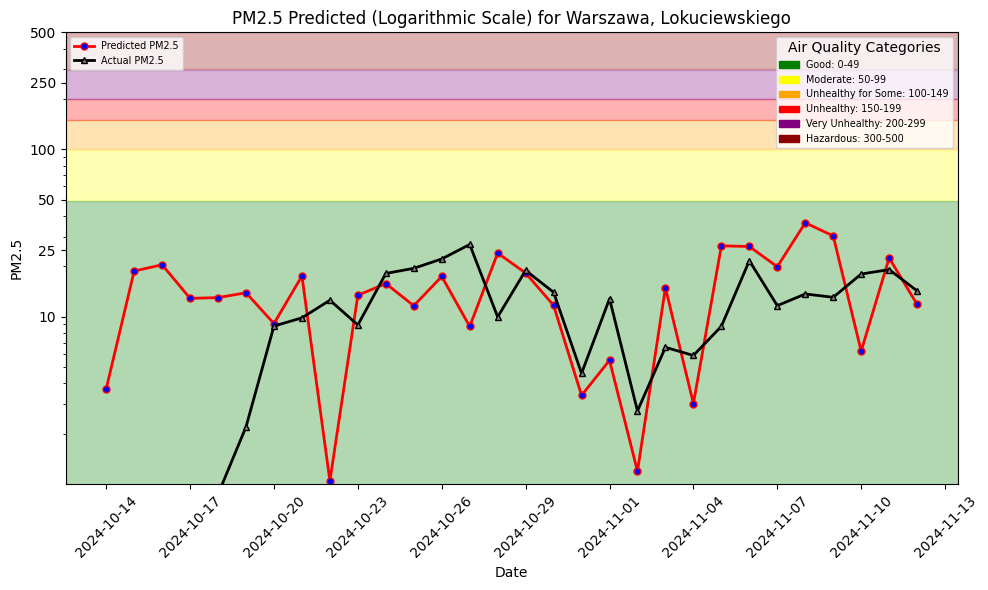

In [ ]:
file_path = images_dir + "/pm25_3lagged_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df.tail(30), file_path, hindcast=True) 
plt.show()

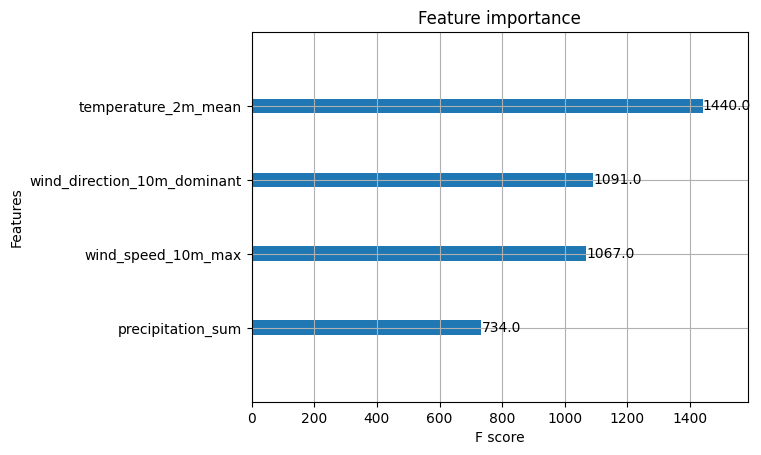

In [22]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [23]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [24]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [25]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [ ]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_3lagged_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality 3 lagged (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/497707 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19484 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/90820 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/120 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/645 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1169565/models/air_quality_xgboost_model/1


Model(name: 'air_quality_xgboost_model', version: 1)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
